In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# Preprocessing
def preproc(dataframe):
    dataframe.index = pd.to_datetime(dataframe.index)
    return dataframe


def get_series(dataframe,col):
    series = dataframe[col]
    return series

In [3]:
# Smoothing
def smooth_by_lowess(series, frac):
    from statsmodels.nonparametric.smoothers_lowess import lowess

    x = np.arange(1, len(series) + 1)
    y = series.to_numpy()
    result = lowess(y, x, frac=frac)
    smoothed_arr = result[:, 1]
    smoothed_series = pd.Series(smoothed_arr, index=series.index, name=series.name)
    return smoothed_series


def smooth_by_spline(series, s):
    from sklearn.preprocessing import MinMaxScaler
    from scipy.interpolate import UnivariateSpline

    x = np.arange(1, len(series) + 1)
    y = series.to_numpy().reshape(-1, 1)

    mms_y = MinMaxScaler()
    scaled_y = mms_y.fit_transform(y).flatten()

    spline = UnivariateSpline(x, scaled_y, s=s)
    scaled_smoothed_y = spline(x)
    smoothed_arr = mms_y.inverse_transform(scaled_smoothed_y.reshape(-1, 1)).flatten()
    smoothed_series = pd.Series(smoothed_arr, index=series.index, name=series.name)
    return smoothed_series

In [4]:
# Inflection points
def inflection_point_by_exrema(arr, window):
    from scipy.signal import argrelextrema

    local_maxima = argrelextrema(arr, np.greater, order=window)[0]
    local_minima = argrelextrema(arr, np.less, order=window)[0]

    inflection_points = sorted(np.concatenate((local_maxima, local_minima)))
    return inflection_points

In [5]:
# Plot
def plot_series(series, smoothed_series=None, points=None):
    plt.figure(figsize=(14, 6))
    plt.plot(series.index, series, label='RAW', c='k', alpha=0.5)
    if smoothed_series is not None:
        plt.plot(smoothed_series.index, smoothed_series, label='Smoothed', c='k', alpha=1)
    if points is not None:
        plt.scatter(series.index[points], series.iloc[points], label='Inflection point', s=200, alpha=0.7, c='b')
    plt.legend()
    plt.show()

In [6]:
kosdaq_df = pd.read_csv("./data/kosdaq_ohlcv.csv", index_col=0)

In [7]:
kosdaq_df = preproc(kosdaq_df)

In [8]:
series = get_series(kosdaq_df, 'close')
smooth_by_lowess_series = smooth_by_lowess(series, 0.05)
smooth_by_spline_series = smooth_by_spline(series, 0.5)

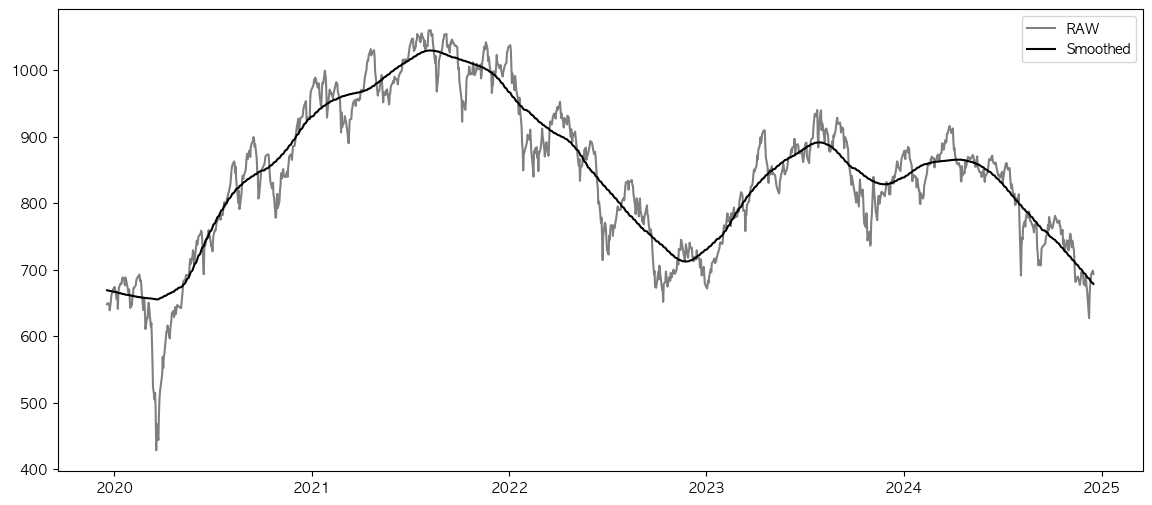

In [9]:
plot_series(series, smooth_by_lowess(series, 0.1))

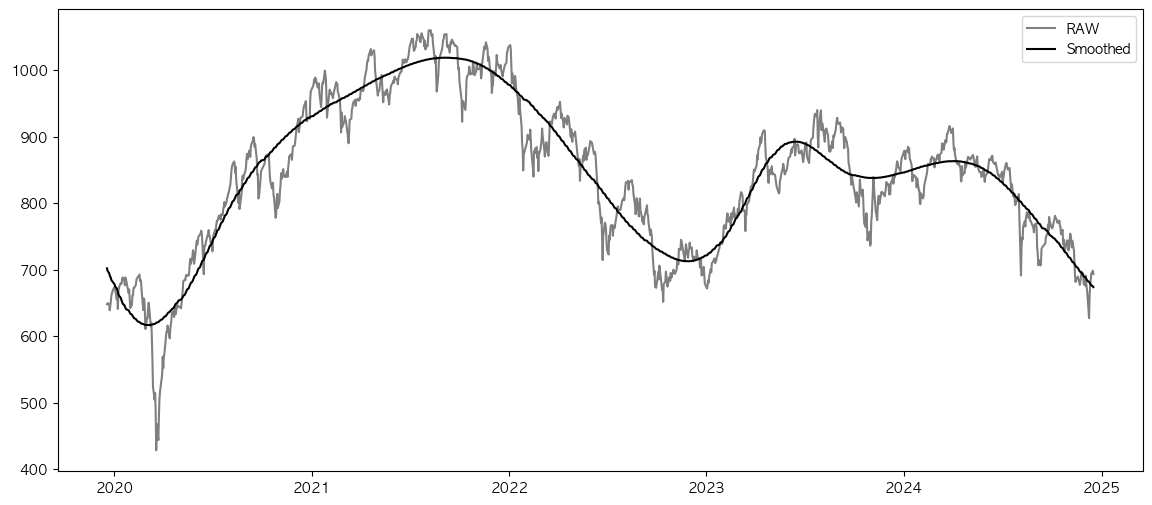

In [10]:
plot_series(series, smooth_by_spline(series, 4))

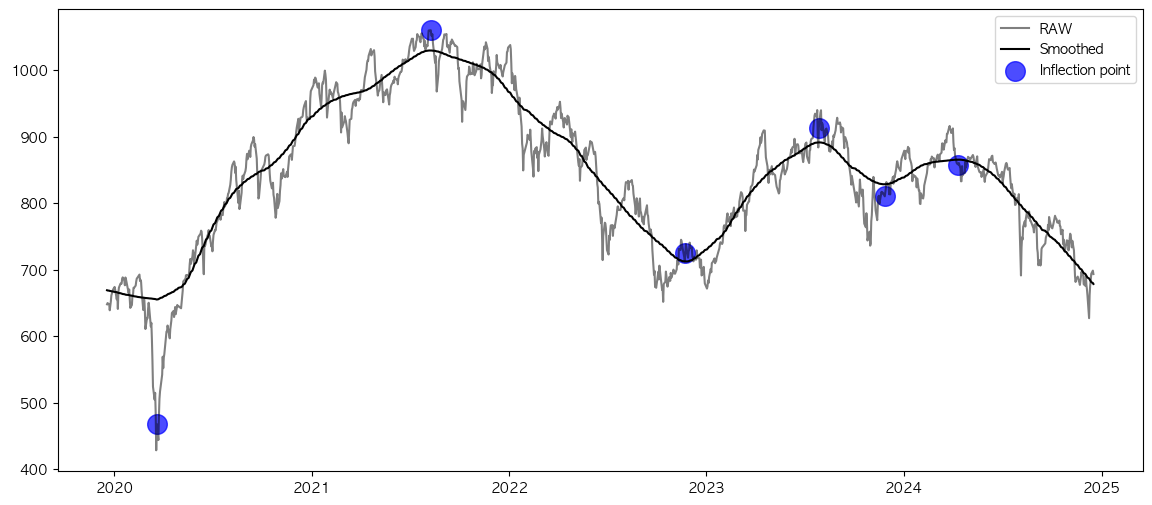

In [11]:
smoothed_series = smooth_by_lowess(series, 0.1)
inflection_points = inflection_point_by_exrema(smoothed_series.to_numpy(), 10)

plot_series(
    series,
    smoothed_series,
    points=inflection_points,
)

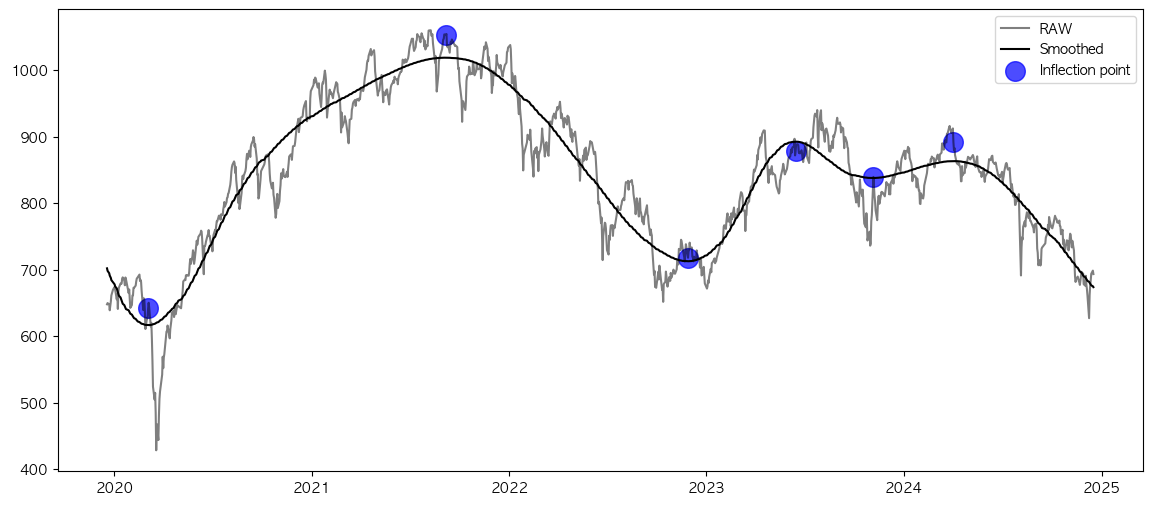

In [12]:
smoothed_series = smooth_by_spline(series, 4)
inflection_points = inflection_point_by_exrema(smoothed_series.to_numpy(), 10)

plot_series(
    series,
    smoothed_series,
    points=inflection_points,
)